# Defining Cell-Division Labels

In [1]:
from tdm.raw.breast_mibi import read_single_cell_df
from tdm.preprocess.ki67 import transform_ki67, is_dividing
from tdm.plot.preprocess.ki67 import plot_marker_distributions, plot_fraction_of_dividing_cells, plot_divisions_per_image

## Read the single-cell dataframe

In [2]:
# Each row corresponds with one cell and there is a column for each marker.
single_cell_df = read_single_cell_df()

In [3]:
# available markers:
list(single_cell_df.columns[12:-10])

['Histone H3',
 'SMA',
 'CK5',
 'CD38',
 'HLA-DR',
 'CK8-18',
 'CD15',
 'FSP1',
 'CD163',
 'ICOS',
 'OX40',
 'CD68',
 'HER2 (3B5)',
 'CD3',
 'Podoplanin',
 'CD11c',
 'PD-1',
 'GITR',
 'CD16',
 'HER2 (D8F12)',
 'CD45RA',
 'B2M',
 'CD45RO',
 'FOXP3',
 'CD20',
 'ER',
 'CD8',
 'CD57',
 'Ki-67',
 'PDGFRB',
 'Caveolin-1',
 'CD4',
 'CD31-vWF',
 'CXCL12',
 'HLA-ABC',
 'panCK',
 'c-Caspase3',
 'DNA1',
 'DNA2']

## Markers have background noise

The plots below show that each marker has a background level of noisy expression. For example, CD8 T-cells express the B-cell marker CD20.

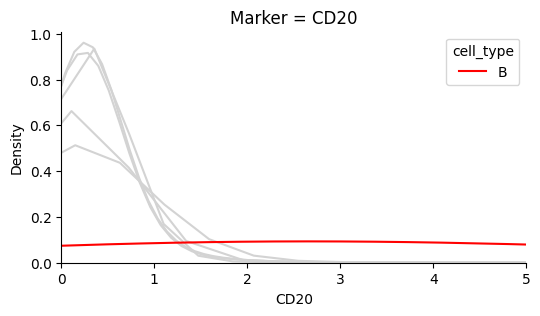

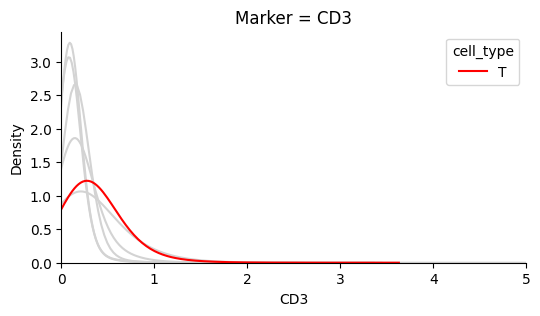

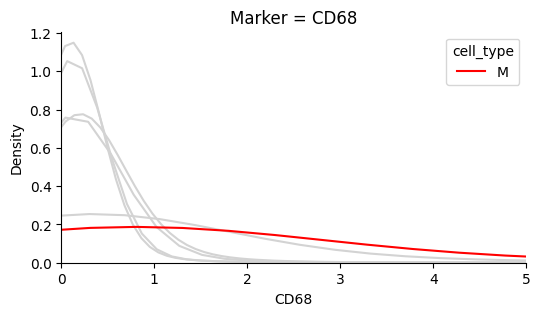

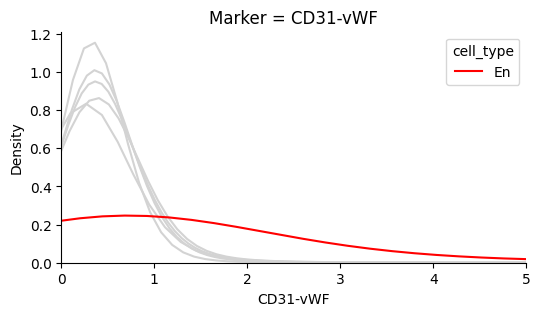

In [4]:
# characteristic markers are useful for determining typical noise magnitude:
marker_cell_type_tuples = [
    ('CD20','B'), # B-cells
    ('CD3','T'), # T-cells
    ('CD68','M'), # macrophages
    ('CD31-vWF', 'En') # endothelial cells
]

for marker, cell_type in marker_cell_type_tuples:
    plot_marker_distributions(single_cell_df, marker, highlight_cell_types=[cell_type])

## Identify the background noise-level of Ki67

In this dataset the background noise falls below ~0.5. We define this value as the typical noise level.

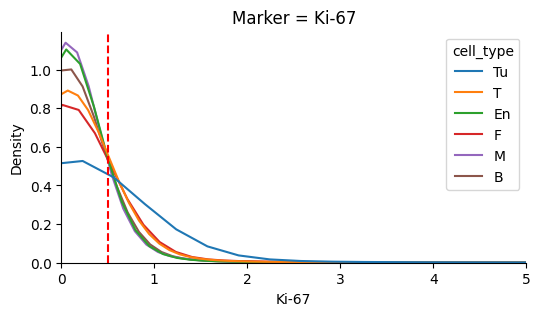

In [5]:
TYPICAL_NOISE = 0.5
plot_marker_distributions(single_cell_df, 'Ki-67', axvline=TYPICAL_NOISE)

## Ki67 values over the level of background noise have similar distributions after standardization

This property is predicted from from the experiments by Uxa et. al (see detailed background below for more details)

/Users/jonathansomer/Documents/phd/projects/testing_git/osdr/src/tdm/preprocess/ki67.py:63: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: _transform_ki67_series(g[ki67_col], typical_noise=typical_noise, drop_values_below_noise=True))


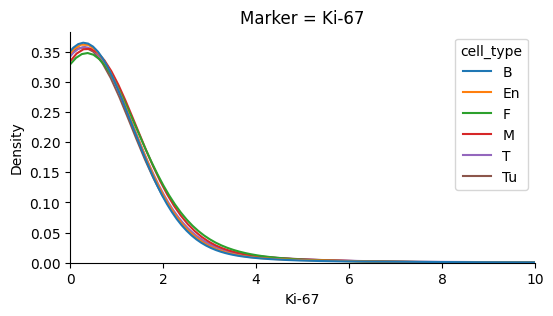

In [6]:
transformed_ki67_single_cell_df = transform_ki67(
    single_cell_df=single_cell_df,
    cell_type_col='cell_type',
    ki67_col='Ki-67',
    typical_noise=TYPICAL_NOISE,
)

plot_marker_distributions(transformed_ki67_single_cell_df, 'Ki-67', xlim=10)

## Add a binary division label to single_cell_df:

In [7]:
single_cell_df["division"] =  is_dividing(
    single_cell_df=single_cell_df, 
    typical_noise=TYPICAL_NOISE, 
    ki67_threshold=0.5, 
    ki67_col='Ki-67'
)

That's it in terms of preparing `single_cell_df`. For quality control measures proceed to the section below.

# Quality Control

## Decrease the ki67 threshold if there aren't enough divisions

It is statistically hard to model the dependence of divisions on neighborhood composition if there are under ~10K cells and 1% divisions (see simulations in our publication). 

If that is the case, either decrease ``ki67_threshold`` in `tdm.preprocess.ki67.is_dividing`, obtain a larger dataset or don't model that cell-type. 

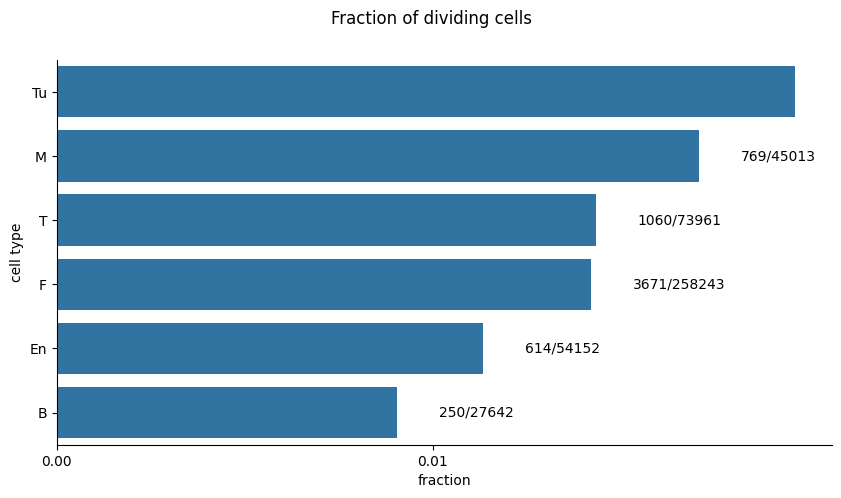

In [8]:
plot_fraction_of_dividing_cells(single_cell_df=single_cell_df)

## Consider excluding outlier images

If an image contributes a disproportionate number of division events it could bias the analysis. 
If you suspect this is a result of problematic staining of an image you should consider excluding it.

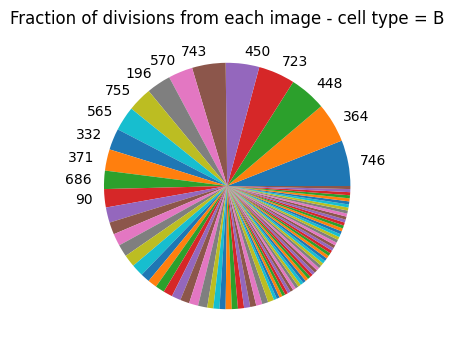

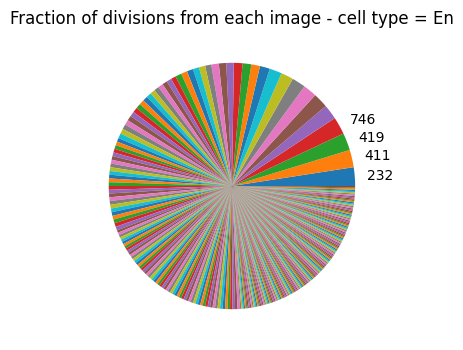

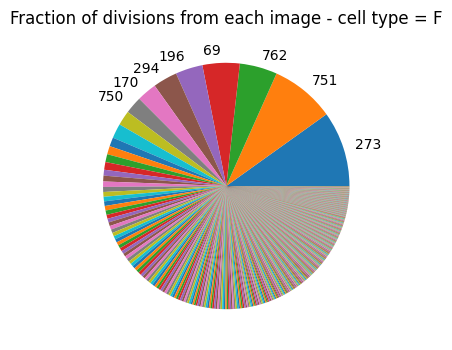

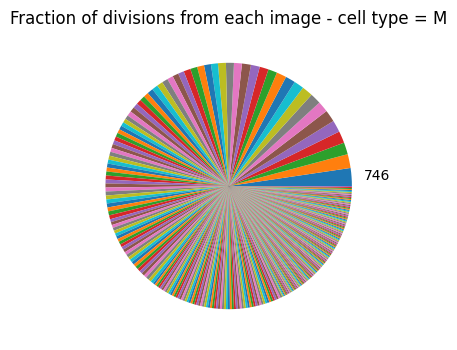

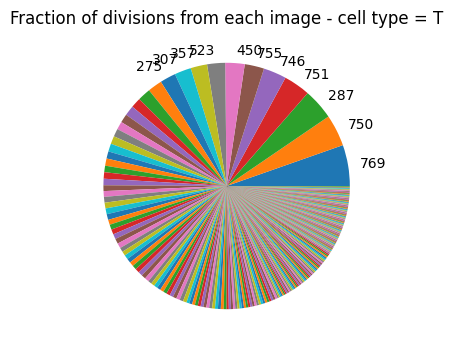

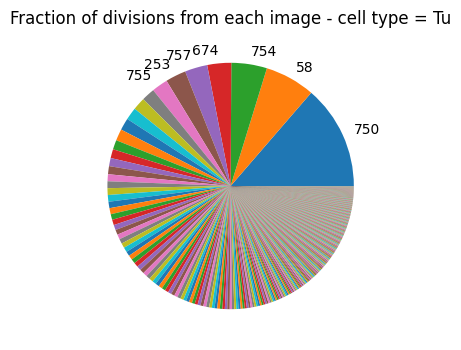

In [9]:
plot_divisions_per_image(single_cell_df)


# Background & Motivation:


[Uxa et. al, 2021](https://www.nature.com/articles/s41418-021-00823-x) have experimentally shown that Ki67 protein and mRNA levels peak towards G2/M phase of the cell cycle:

<img src="../_static/ki67_uxa.png" alt="Ki67 kinetics from Uxa et. al" width="400"/>

Note that the shapes of the curves are preserved, up to a scaling factor, between two different human cell lines (blue, yellow) and a mouse cell line (gray). 

If we could define a threshold of, for example, 80% of the **maximal** Ki67 value observed for each cell type, then Ki67 levels persist above that threshold for dt = ~3 hours when approaching mitosis. Any cutoff that would meet all curves at the same x% of the maximum corresponds with a different, but consistent, dt. 

The challenge in defining the cutoffs is that we do not actually observe a maximal value of Ki67 for any cell-type. The experiments by Uxa et. al present aggregate values at each time point. These are summary statistics of distributions that do not necessarily have a maximum value, i.e the mean of the distribution peaks over time but not necessarily the actual ki67 value. 

In addition, the overall distribution of Ki67 we observe depends on the division rates of all cells in the sample, as well as the scale and shape of the distribution at each time point, making definition of this cutoff challenging. 

Note that any strategy based on quantiles would pre-determine the fraction of dividing cells so cannot be applied here. That is, we can't simply use the 99th quantile to define dividing cells.

Based on the results from [Uxa et. al, 2021](https://www.nature.com/articles/s41418-021-00823-x), we hypothesized that conditioned on the event that Ki67 > 0 (which roughly corresponds with an "initiation" of division), distributions of Ki67 would have similar shapes, but scaled differently. Conditioning on this event allows defining the cutoffs without dealing with the great variation in division rates between cell types or within different neighborhoods. This hypothesis indeed holds (see distribution of transformed Ki67 in this notebook or in our [publication](https://www.biorxiv.org/content/10.1101/2024.04.22.590503v1)).

For each cell type, we divide Ki67 values greater than zero by the standard deviation, thus bringing the distributions to an equivalent scale, we then select a single cutoff to use for all cell types. We cannot infer from this cutoff what dt is exactly, but it should be consistent among all cell types and on the order of a few hours. 

One final technical challenge: there is a background level of noise that biases the distribution of Ki67 > 0 values. The fraction of cells with zero-valued Ki67 varies significantly between cell types. Cells that are more rapidly dividing have less zeros (e.g Tumor cells). As a result, the distribution of Ki67 > 0 is biased by the noise applied to a different fraction of cells with zero-valued Ki67. That is, Ki67 > 0 is a mixture between the noise distribution over zero-valued cells, and the distribution of Ki67 for cells that had a value greater than zero before the noise (of course noise is also applied to them). Background noise levels can be seen for instance by plotting the distribution of various protein markers on cell-types that should not typically express them (such as: CD4 expression by fibroblasts). A "typical-noise" value of 0.5 was heuristically chosen here as a point that met most curves after the peak of the distribution mass.

Thus the transformation applied to Ki67 values is:

1. Select: $\text{Ki67} > 0.5$
2. Shift: $\text{Ki67} - 0.5$
2. Standardize: $\text{Ki67} / \text{std}(\text{Ki67})$